In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
import xarray as xr
from scipy.stats import pearsonr
from pyproj import datadir
datadir.set_data_dir("/home/jupyter-daniela/.conda/envs/peru_environment/share/proj")


In [ ]:
class OceanPartialCorrelation:
    def __init__(self, sss, sst, rho):
        """
        sss, sst, rho: xarray.DataArray con dims (time, latitude, longitude)
        Se eliminan las fechas problemáticas antes de intersectar.
        """
        if np.datetime64("2023-12-31") in sss.time.values:
            sss = sss.sel(time=sss.time != np.datetime64("2023-12-31"))
        if np.datetime64("2024-12-30") in sst.time.values:
            sst = sst.sel(time=sst.time != np.datetime64("2024-12-30"))

        common_times = np.intersect1d(
            np.intersect1d(sss.time.values, sst.time.values),
            rho.time.values
        )

        self.sss = sss.sel(time=common_times)
        self.sst = sst.sel(time=common_times)
        self.rho = rho.sel(time=common_times)

        self.results = pd.DataFrame()

    def calcular(self, min_registros=21, standardize=True):
        latitudes = self.sss.latitude.values
        longitudes = self.sss.longitude.values

        resultados = []
        for i, lat in enumerate(latitudes):
            for j, lon in enumerate(longitudes):
                sss_series = self.sss.isel(latitude=i, longitude=j).values
                sst_series = self.sst.isel(latitude=i, longitude=j).values
                rho_series = self.rho.isel(latitude=i, longitude=j).values

                mask = np.isfinite(sss_series) & np.isfinite(sst_series) & np.isfinite(rho_series)
                if np.count_nonzero(mask) > min_registros:
                    x_sss = sss_series[mask]
                    x_sst = sst_series[mask]
                    x_rho = rho_series[mask]

                    if standardize:
                        x_sss = (x_sss - np.nanmean(x_sss)) / np.nanstd(x_sss)
                        x_sst = (x_sst - np.nanmean(x_sst)) / np.nanstd(x_sst)
                        x_rho = (x_rho - np.nanmean(x_rho)) / np.nanstd(x_rho)

                    r_rho_sst = pearsonr(x_rho, x_sst)[0]
                    r_rho_sss = pearsonr(x_rho, x_sss)[0]
                    r_sst_sss = pearsonr(x_sst, x_sss)[0]

                    r_partial_rho = (r_rho_sst - r_rho_sss * r_sst_sss) / np.sqrt(
                        (1 - r_rho_sss**2) * (1 - r_sst_sss**2)
                    )
                    r_partial_sst = (r_rho_sss - r_rho_sst * r_sst_sss) / np.sqrt(
                        (1 - r_rho_sst**2) * (1 - r_sst_sss**2)
                    )

                    resultados.append({
                        "latitude": lat,
                        "longitude": lon,
                        "corr_rho_sst": r_rho_sst,
                        "corr_rho_sss": r_rho_sss,
                        "corr_sst_sss": r_sst_sss,
                        "partial_rho": r_partial_rho,
                        "partial_sst": r_partial_sst,
                        "n": np.count_nonzero(mask)
                    })

        self.results = pd.DataFrame(resultados)

    def visualizar(self, variable="partial_rho", shapefile_path=None):
        if self.results.empty:
            raise ValueError("Primero debes ejecutar calcular()")

        if variable not in ["partial_rho", "partial_sst", "corr_rho_sst", "corr_rho_sss", "corr_sst_sss"]:
            raise ValueError(f"Variable '{variable}' no reconocida")

        grid = self.results.pivot_table(index="latitude", columns="longitude", values=variable)
        lons = grid.columns.values
        lats = grid.index.values
        Z = grid.values

        fig = plt.figure(figsize=(8, 8))
        ax = plt.axes([0.05, 0.05, 0.85, 0.9])

        if shapefile_path:
            boundary = gpd.read_file(shapefile_path)
            boundary.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5)

        levels = np.linspace(-1, 1, 21)
        norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

        mesh = ax.pcolormesh(lons, lats, Z, cmap="RdBu_r", shading="auto", norm=norm)

        cax = plt.axes([0.92, 0.1, 0.02, 0.8])
        plt.colorbar(mesh, cax=cax, ticks=levels, label=variable)

        ax.set_xlim([lons.min(), lons.max()])
        ax.set_ylim([lats.min(), lats.max()])
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.set_title(f"Mapa de {variable}", fontsize=10, loc="left")
        plt.show()



In [27]:

sss_ds = xr.open_dataset("/home/jupyter-daniela/suyana/peru_production/features/OISSS_sss_weekly_2015-2024_4N_74W_16S_83W_0.25deg.nc")["sss"]
sst_ds = xr.open_dataset("/home/jupyter-daniela/suyana/peru_production/features/SST_weekly_2015-2024_4N_74W_16S_83W_0.25deg.nc")["sst"]
rho_ds = xr.open_dataset("/home/jupyter-daniela/suyana/peru_production/features/SSD_weekly_2015-2024_4N_74W_16S_83W_0.25deg.nc")["rho_surface"]


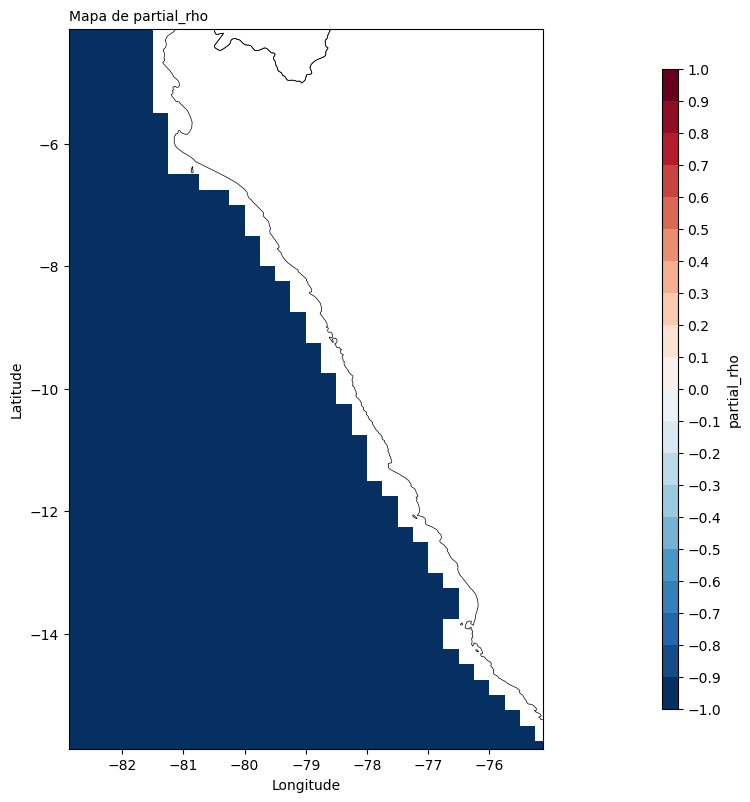

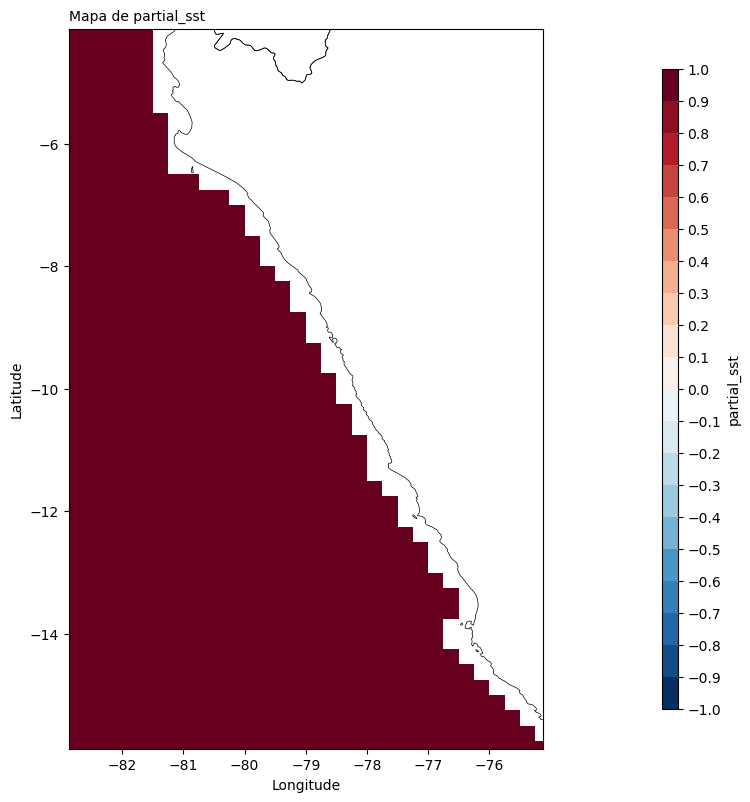

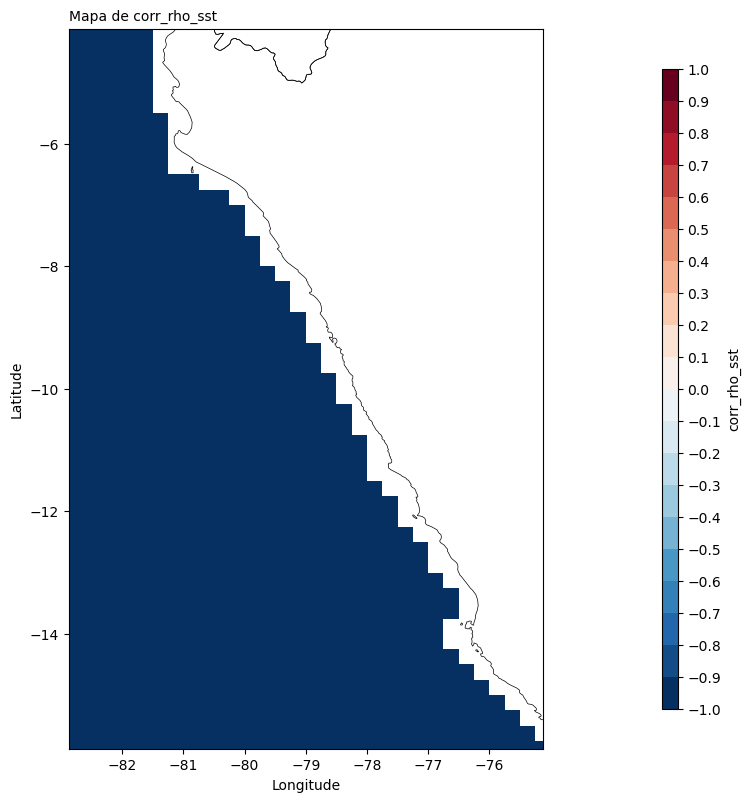

In [29]:

opc = OceanPartialCorrelation(sss_ds, sst_ds, rho_ds)
opc.calcular(min_registros=21)

opc.visualizar(variable="partial_rho", shapefile_path="/home/jupyter-daniela/suyana/geometries/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")

opc.visualizar(variable="partial_sst", shapefile_path="/home/jupyter-daniela/suyana/geometries/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")

opc.visualizar(variable="corr_rho_sst", shapefile_path="/home/jupyter-daniela/suyana/geometries/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")